In [1]:
from torchvision import transforms

image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

transformer = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize(image_mean, image_std)])

transformer_augmented = transforms.Compose([    
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)])

In [2]:
import torchvision

# загружаем тренировочный датасет CIFAR10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transformer_augmented)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
# загружаем тестовый датасет CIFAR10
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transformer)

Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# Создаем загрузчики для датасетов (DataLoader)

import torch

batch_size_train = 64
batch_size_test = 100

#Загрузчик для тренировочного сета
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train,
  shuffle=True)

#Загрузчик для тестового сета
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, 
  shuffle=True)

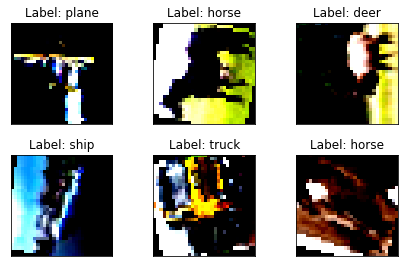

In [7]:
# Визуализируем несколько изображений из обучающего датасета

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i]), interpolation='none')
  plt.title(f"Label: {classes[example_targets[i]]}")
  plt.xticks([])
  plt.yticks([])

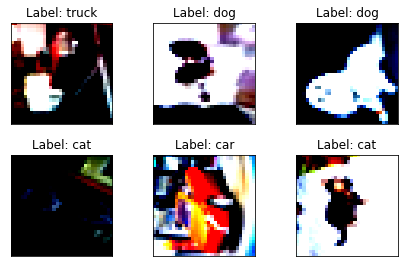

In [8]:
#Визуализируем изображения из тестового датасета

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i]), interpolation='none')
  plt.title(f"Label: {classes[example_targets[i]]}")
  plt.xticks([])
  plt.yticks([])

In [9]:
# подключаем GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


***
Построим полносвязную нейронную сеть - **многослойный перцептрон**

In [10]:
from torch import nn

In [11]:
# Определяем архитектуру модели
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.relu_mod = nn.Sequential(
            nn.Linear(32*32*3, 2000),
            nn.BatchNorm1d(2000), #бач-нормализация
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 10))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.relu_mod(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu_mod): Sequential(
    (0): Linear(in_features=3072, out_features=2000, bias=True)
    (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2000, out_features=500, bias=True)
    (4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [12]:
#задаем функцию потерь и оптимизацию градиента
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [13]:
#функция для обучения
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
#функция для расчета точности на тесте
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
#инизиализация модели
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.354616  [    0/50000]
loss: 1.878786  [ 6400/50000]
loss: 1.546144  [12800/50000]
loss: 1.881771  [19200/50000]
loss: 1.792507  [25600/50000]
loss: 1.717752  [32000/50000]
loss: 1.808676  [38400/50000]
loss: 1.702042  [44800/50000]
Test Error: 
 Accuracy: 39.0%, Avg loss: 1.669619 

Epoch 2
-------------------------------
loss: 1.548227  [    0/50000]
loss: 1.712911  [ 6400/50000]
loss: 1.749369  [12800/50000]
loss: 1.531419  [19200/50000]
loss: 1.694378  [25600/50000]
loss: 1.799280  [32000/50000]
loss: 1.535402  [38400/50000]
loss: 1.792462  [44800/50000]
Test Error: 
 Accuracy: 40.4%, Avg loss: 1.643772 

Epoch 3
-------------------------------
loss: 1.661502  [    0/50000]
loss: 1.745234  [ 6400/50000]
loss: 1.281250  [12800/50000]
loss: 1.481034  [19200/50000]
loss: 1.599736  [25600/50000]
loss: 1.761388  [32000/50000]
loss: 1.480329  [38400/50000]
loss: 1.622266  [44800/50000]
Test Error: 
 Accuracy: 44.4%, Avg loss: 1.573272 

Epoc

Точность модели оказалась примерно **50%**
***
Посмотрим как справится **свёрточная нейронная сеть**

In [15]:
# Создаем класс сверточной нейронной сети
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(            
          # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности
          nn.Conv2d(3, 16, kernel_size=5, padding=2),
          # Важно! Батч-нормализация всегда идёт до функции активации!
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2),
          nn.Dropout(0.2),

          # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.
          nn.Conv2d(16, 32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(2),
          # Важно! Дропаут идёт после функции активации!
          nn.Dropout(0.2))
        
        self.classifier = nn.Sequential(
          # Блок 3: Линейный слой поверх карт активации
          nn.Linear(2048, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(0.2),

          # Блок 4: Классификационный слой
          nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Переносим CNN на device
model = CNN().to(device)

In [16]:
#функция для отрисовки графика обучения
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [17]:
#Функция для обучения
from collections import defaultdict
import time
from IPython.display import clear_output


def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=30
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Так как это не обучающие батчи, градиент не нужен
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 30 of 30 took 78.473s
  training loss (in-iteration): 	0.775976
  validation loss (in-iteration): 	0.766462
  training accuracy: 			73.03 %
  validation accuracy: 			75.23 %


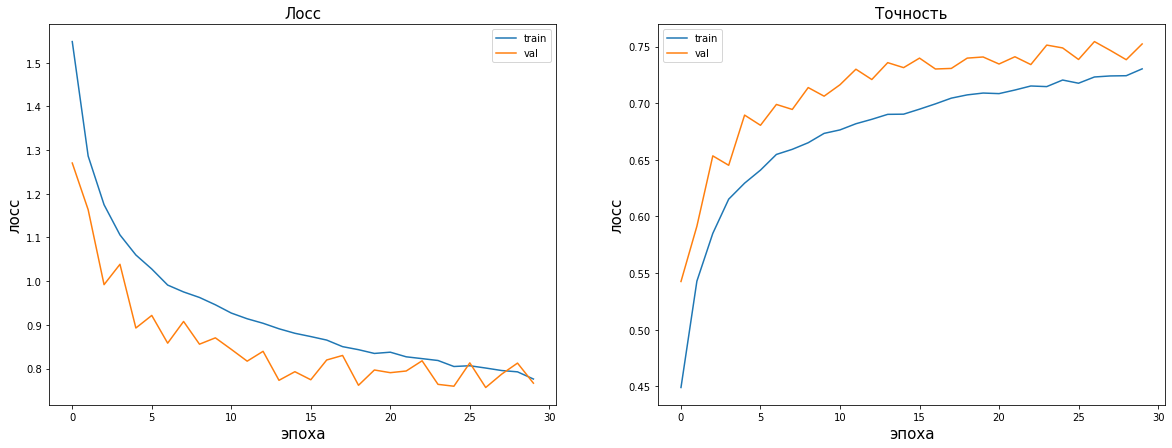

In [19]:
#функция потерь и оптимизация градиента:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучим модель
model, history = train(
    model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=30)

ВЫВОД: точность **свёрточной нейронной сети** оказалась выше - **75%**

***

**TransferLearning:** проверим предобученную нейронную сеть **VGG11**

In [18]:
import torchvision.models as models

# Загрузим предобученную модель и посмотрим на нее
model_vgg = models.vgg11_bn(pretrained=True)

print(model_vgg)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [19]:
# Фиксируем значение градиента на каждом слое, кроме последнего
for p in model_vgg.parameters():
    p.requires_grad = False
# меняем в последнем слое количество классов на 10
in_features = model_vgg.classifier[-1].in_features

from torchvision import transforms

model_vgg.classifier[-1] = nn.Linear(in_features, 10) 

# помещаем модель в ГПУ
model_vgg = model_vgg.to(device)

Epoch 10 of 10 took 27.787s
  training loss (in-iteration): 	1.585303
  validation loss (in-iteration): 	1.368741
  training accuracy: 			44.89 %
  validation accuracy: 			53.27 %


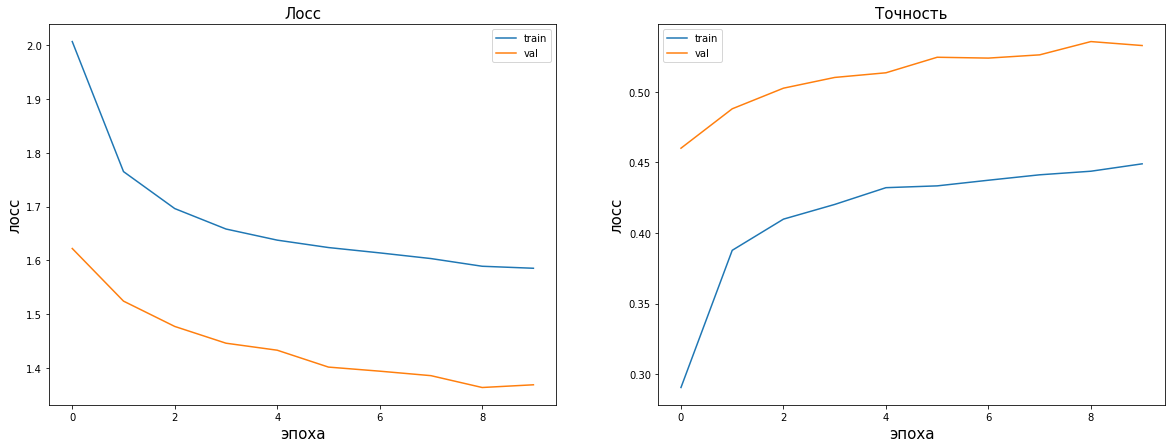

In [20]:
# Обучаем сеть

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.classifier[-1].parameters(), lr=1e-3)

model, history = train(
    model_vgg, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10)

ВЫВОД: Точность предобученной модели vgg11 составила **55%**
***
**TransferLearning2:** Предобученная модель **ResNet152**

In [21]:
import torchvision.models as models
# Load pre-trained model
model_resnet152 = torchvision.models.resnet152(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [22]:
# Фиксируем значение градиента на каждом слое, кроме последнего
for p in model_resnet152.parameters():
    p.requires_grad = False
# меняем в последнем слое количество классов на 10
in_features = model_resnet152.fc.in_features

model_resnet152.fc = nn.Linear(in_features, 10) 

# помещаем модель в ГПУ
model_resnet152 = model_resnet152.to(device)

Epoch 10 of 10 took 41.596s
  training loss (in-iteration): 	1.639537
  validation loss (in-iteration): 	26.329848
  training accuracy: 			43.04 %
  validation accuracy: 			41.03 %


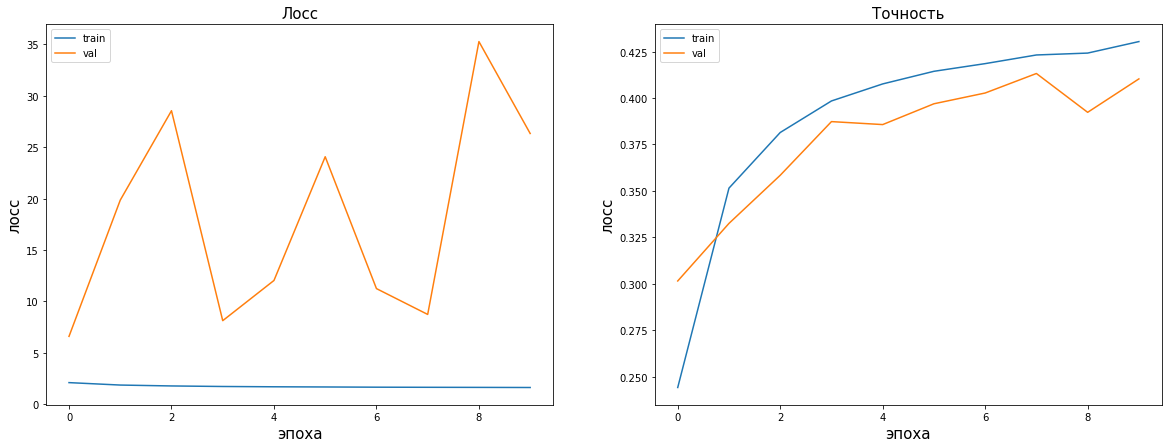

In [23]:
#задаем функцию потерь, оптимизацию градиента в последнем слое и обучаем модель
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_resnet152.fc.parameters(), lr=1e-3)

model_resnet152, history = train(
    model_resnet152, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10)

**ВЫВОД:** точность предобученной модели **ResNet152** составила **50%**
***
Применение предобученной сети **EfficientNet** (не TransferLearning, а именно готовая сеть для классификации изображений)

In [12]:
# Установим библиотеку для EfficientNet PyTorch
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4f6e58c38fc69434db9c5962d047224d67ba4fc9fc71fc9d7ee743e467ff057f
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [13]:
from efficientnet_pytorch import EfficientNet

In [14]:
# Выберем одну из разновидносетй посмотрим размер входного изображения
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)

image_size

224

In [15]:
# Загрузим названия классов
import json
from urllib.request import urlopen

data_url = "https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt"

labels_map = json.load(urlopen(data_url))
labels_map = [labels_map[str(i)] for i in range(1000)]

print("Num classes:", len(labels_map))
labels_map[:5]

Num classes: 1000


['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [23]:
# Применим сеть к загруженной картинке
import time

model = EfficientNet.from_pretrained(model_name)
model.eval()
model.to(device)

start = time.time()
with torch.no_grad():
  for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
  logits = model(X)
  preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()
print("testing time: ", time.time() - start, " seconds")

print('----------------------------------------------------------------------------------')
for idx in preds:
  for j in range(0,len(idx)):  
    label = labels_map[idx[j]]
    prob = torch.softmax(logits, dim=1)[0, idx[j]].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

Loaded pretrained weights for efficientnet-b0
testing time:  6.225421190261841  seconds
----------------------------------------------------------------------------------
slide rule, slipstick                                                       (0.61%)
maze, labyrinth                                                             (0.52%)
photocopier                                                                 (0.49%)
tiger beetle                                                                (0.47%)
Arabian camel, dromedary, Camelus dromedarius                               (0.39%)
medicine chest, medicine cabinet                                            (0.23%)
dung beetle                                                                 (0.25%)
dishrag, dishcloth                                                          (0.11%)
echidna, spiny anteater, anteater                                           (0.11%)
walking stick, walkingstick, stick insect                                

TypeError: ignored

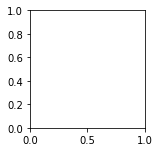

In [30]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(X[i]), interpolation='none')
  plt.title(f"Label: {classes[y[i]]}")
  plt.xticks([])
  plt.yticks([])

*** 
**Ошибки в датасете с kaggle**

In [39]:
#Устанавливаем библиотеку Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
#создаем каталог с именем .kaggle
! mkdir ~/.kaggle

In [44]:
#копируем API в зозданный каталог
! cp kaggle.json ~/.kaggle/

In [45]:
#Назначаем необходимое разрешение к этому файлу
! chmod 600 ~/.kaggle/kaggle.json

In [46]:
#Загружаем соревнование с сайта kaggle
! kaggle competitions download cifar-10

 99% 706M/715M [00:05<00:00, 144MB/s]
100% 715M/715M [00:05<00:00, 143MB/s]


In [47]:
#распаковываем архив
! unzip cifar-10

Archive:  cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [48]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 357 kB 11.4 MB/s 
     |████████████████████████████████| 378 kB 52.8 MB/s 
     |████████████████████████████████| 2.3 MB 53.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 139 kB 53.3 MB/s 


In [49]:
#распаковываем архивы 7z. Train:
import py7zr
with py7zr.SevenZipFile('train.7z', mode='r') as z:
    z.extractall()

In [50]:
#Test:
with py7zr.SevenZipFile('test.7z', mode='r') as c:
    c.extractall()

In [51]:
import pandas as pd
import numpy as np

#разметка обучающего датасета
train_labels = pd.read_csv('trainLabels.csv')
train_labels.tail()

,id,label
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [52]:
razmetka_train = train_labels.set_index('id').to_dict()['label']

In [53]:
classes = train_labels['label'].unique()

#создаем папки со вложенными классами для обучающего датасета
import os
os.mkdir('TRAIN')
for x in classes:
  os.makedirs ('TRAIN/'+x)

In [54]:
#разносим файлы из обущающего набора по классам
for key, value in razmetka_train.items():
  os.replace (f'/content/train/{key}.png', f'/content/TRAIN/{value}/{key}.png')

In [47]:
import torchvision
from torchvision import transforms
# load dataset using torchvision.datasets.ImageFolder
training_data = torchvision.datasets.ImageFolder(r'TRAIN', transform=transforms.ToTensor())

In [26]:
from torch.utils.data import DataLoader

batch_size = 50

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)

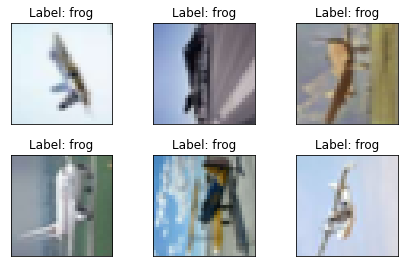

In [51]:
# Визуализируем несколько изображений из обучающего датасета
from matplotlib import pyplot as plt
%matplotlib inline

examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i]), interpolation='none')
  plt.title(f"Label: {classes[example_targets[i]]}")
  plt.xticks([])
  plt.yticks([])

Text(0.5, 1.0, 'Label: frog')

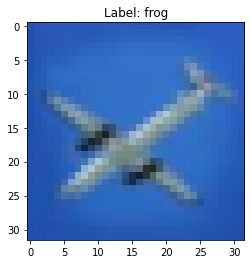

In [45]:
plt.imshow(np.transpose(example_data[49]), interpolation='none')
plt.title(f"Label: {classes[example_targets[49]]}")

In [52]:
classes

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

In [56]:
from PIL import Image
from pathlib import Path

In [57]:
test_dataset = Path('/content/test')

In [58]:
images = [p.resolve() for p in test_dataset.glob('*') if p.suffix in {'.png'}]

In [59]:
# В тестовом наборе должно было быть 10 000 изображений. У нас оказалось 300 000...
len(images)

300000

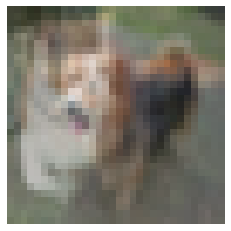

In [81]:
rand_idx = np.random.randint(len(images))
img = Image.open (images[rand_idx])
plt.imshow (img)
plt.axis ('off')
plt.show()